In [14]:

# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')


In [29]:

# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')
print(data.info())
data.head()
      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB
None


,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True


In [30]:

# Data preparation -- 'Time' is stored as a string; convert it to actual time
# ==============================================================================
data = data.copy()
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data.head(2)


,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True


In [31]:

# One of the first analyses to be carried out when working with time series is to check that the series is complete.

# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                              end=data.index.max(),
                              freq=data.index.freq)).all()

print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")


Number of rows with missing values: 0.0


In [32]:

# Although the data is at 30 minute intervals, the aim is to create a model capable of predicting hourly electricity 
# demand, so the data needs to be aggregated. This type of transformation can be done very quickly by combining the 
# Pandas time type index and its resample() method.

# Aggregating in 1H intervals
# ==============================================================================
# The Date column is eliminated so that it does not generate an error when aggregating.
# The Holiday column does not generate an error since it is Boolean and is treated as 0-1.
data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left', label ='right').mean()
data


,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0
...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,0.0
2014-12-31 10:00:00,3909.230704,20.300,0.0
2014-12-31 11:00:00,3900.600901,19.650,0.0


In [33]:

# The dataset starts on 2011-12-31 14:00:00 and ends on 2014-12-31 13:00:00. The first 10 and the last 13 records 
# are discarded so that it starts on 2012-01-01 00:00:00 and ends on 2014-12-30 23:00:00. In addition, in order 
# to optimize the hyperparameters of the model and evaluate its predictive ability, the data is divided into 3 
# sets, training, validation and test.

# Split data into train-val-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00'].copy()
end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates      : 2012-01-01 00:00:00 --- 2013-12-31 23:00:00  (n=17544)
Validation dates : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00  (n=8016)
Test dates       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00  (n=720)


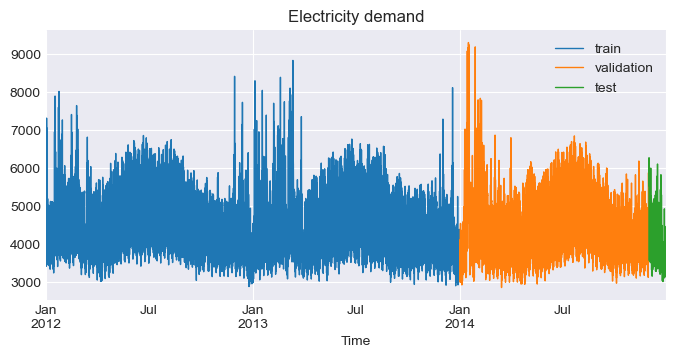

In [34]:

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data_train.Demand.plot(ax=ax, label='train', linewidth=1)
data_val.Demand.plot(ax=ax, label='validation', linewidth=1)
data_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity demand')
ax.legend()


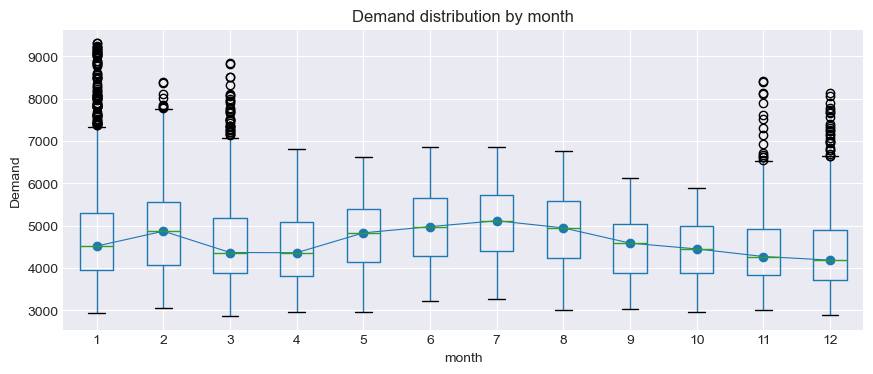

In [46]:

# Boxplot for Annual Seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 4))
data['month'] = data.index.month
data.boxplot(column='Demand', by='month', ax=ax,)
data.groupby('month')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by month')
fig.suptitle('');


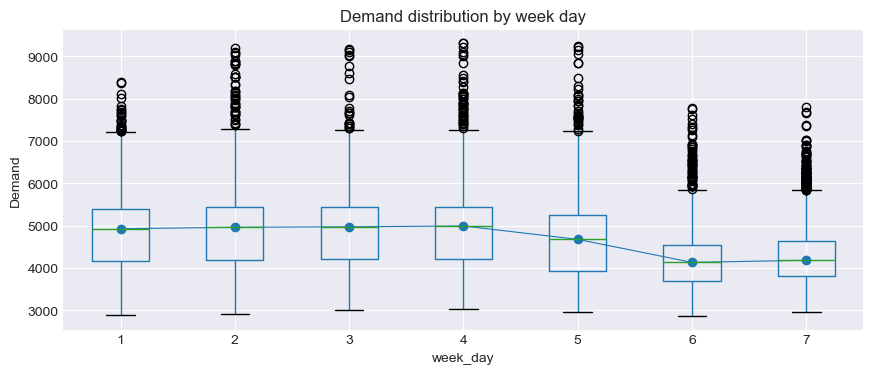

In [45]:

# Boxplot for Weekly Seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 4))
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='Demand', by='week_day', ax=ax)
data.groupby('week_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by week day')
fig.suptitle('');


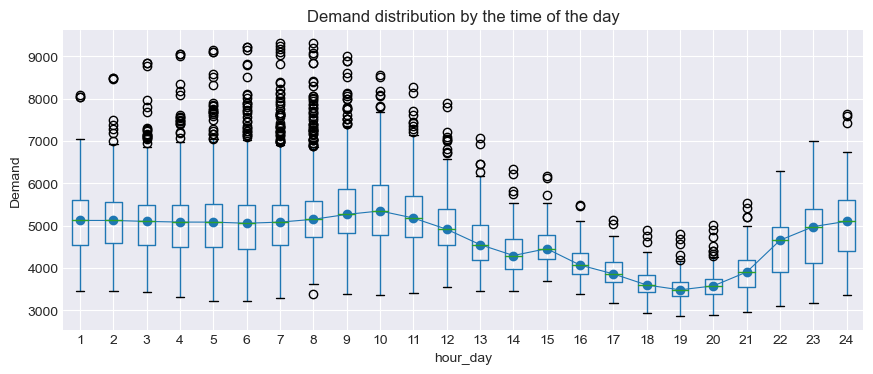

In [44]:

# Boxplot for Daily Seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 4))
data['hour_day'] = data.index.hour + 1
data.boxplot(column='Demand', by='hour_day', ax=ax)
data.groupby('hour_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by the time of the day')
fig.suptitle('');


Text(0, 0.5, 'Holiday')

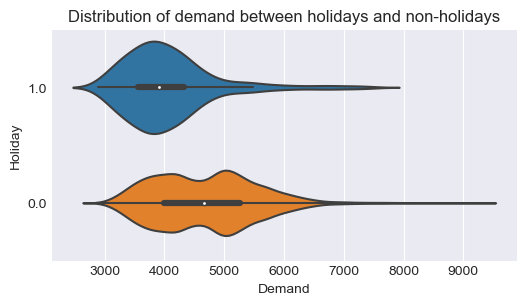

In [47]:

# Violinplot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
sns.violinplot(
    x       = 'Demand',
    y       = 'Holiday',
    data    = data.assign(Holiday = data.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribution of demand between holidays and non-holidays')
ax.set_xlabel('Demand')
ax.set_ylabel('Holiday')


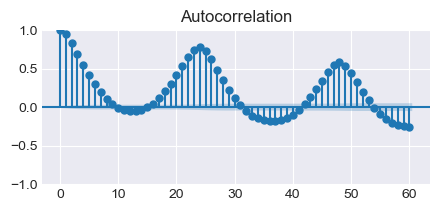

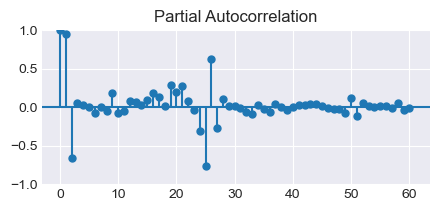

In [48]:

# The autocorrelation and partial autocorrelation plots show a clear relationship between demand in one hour 
# and the previous hours, and between demand in one hour and the same hour in previous days. This type of 
# correlation is an indication that autoregressive models can work well. 

# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(data.Demand, ax=ax, lags=60)
plt.show()

# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(data.Demand, ax=ax, lags=60)
plt.show()


In [50]:

# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=data.loc[:end_validation, 'Demand'])
forecaster


ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-08-28 20:59:57 
Last fit date: 2023-08-28 20:59:57 
Skforecast version: 0.9.1 
Python version: 3.10.9 
Forecaster id: None 

In [51]:

# In time series forecasting, the process of backtesting consists of evaluating the performance of a predictive 
# model by applying it retrospectively to historical data. Therefore, it is a special type of cross-validation 
# applied to the previous period(s).

# The purpose of backtesting is to evaluate the accuracy and effectiveness of a model and identify any potential 
# issues or areas of improvement. By testing the model on historical data, one can assess how well it performs on 
# data that it has not seen before. This is an important step in the modeling process, as it helps to ensure that 
# the model is robust and reliable.

# Backtest
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data.loc[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                    )


Information of backtesting process
----------------------------------
Number of observations used for initial training: 25560
Number of observations used for backtesting: 720
    Number of folds: 30
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-01 00:00:00 -- 2014-12-01 23:00:00  (n=24)
Fold: 1
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-02 00:00:00 -- 2014-12-02 23:00:00  (n=24)
Fold: 2
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-03 00:00:00 -- 2014-12-03 23:00:00  (n=24)
Fold: 3
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-04 00:00:00 -- 2014-12-04 23:00:00  (n=24)
Fold: 4
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-05

  0%|          | 0/30 [00:00<?, ?it/s]

Backtest error: 289.51913315825783


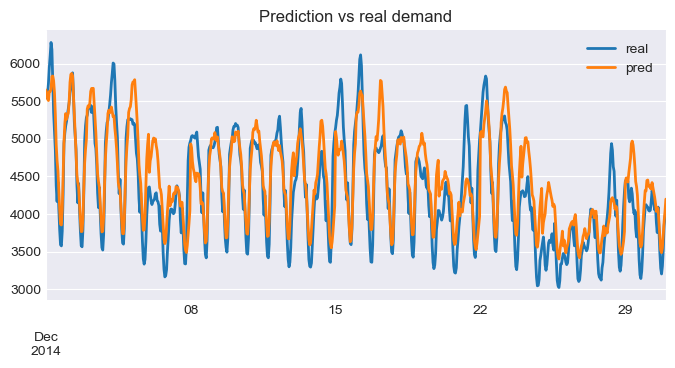

In [52]:

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'Demand'].plot(ax=ax, linewidth=2, label='real')
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();



# Backtest error
# ==============================================================================
print(f'Backtest error: {metric}')


In [57]:

# The trained ForecasterAutoreg object used the first 24 lags and a Ridge model with the default hyperparameters. 
# However, there is no reason why these values are the most appropriate.

# To identify the best combination of lags and hyperparameters, a Grid Search with validation by Backtesting is 
# used. This process consists of training a model with different combinations of hyperparameters and lags and 
# evaluating its predictive capacity. In the search process, it is important to evaluate the models using only 
# the validation data and not to include the test data, which is only used to evaluate the final model.

# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24, # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

# Lags used as predictors
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'Demand'],
                   steps              = 24,
                   metric             = 'mean_absolute_error',
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   initial_train_size = len(data[:end_train]),
                   refit              = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = True
               )


Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'alpha': 215.44346900318823}
  Backtesting metric: 257.84309845082794



In [58]:

# Grid Search results
# ==============================================================================
print(results_grid)

forecaster


                                                 lags  \
26                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
25                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
24                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
23                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
22                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
21                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
20                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
12  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
13  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
14  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
27                  [1, 2, 3, 23, 24, 25, 47, 48, 49]   
16  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
17  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
18  [1, 2, 3, 4, 5, 6, 7, 8, 9,

ForecasterAutoreg 
Regressor: Ridge(alpha=215.44346900318823, random_state=123) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 215.44346900318823, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-08-28 22:23:16 
Last fit date: 2023-08-28 22:24:16 
Skforecast version: 0.9.1 
Python version: 3.10.9 
Forecaster id: None 

  0%|          | 0/30 [00:00<?, ?it/s]

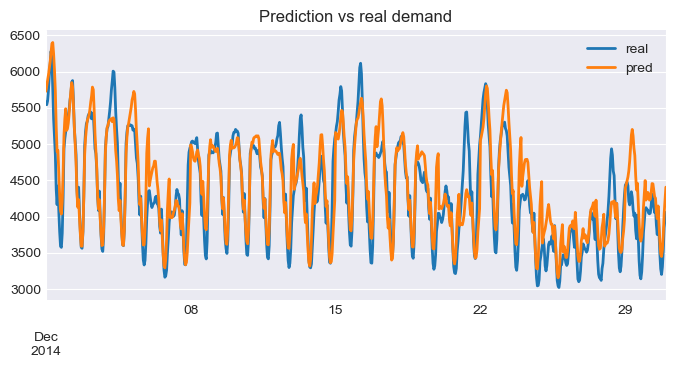

In [59]:

# Backtest final model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Demand'],
                          steps              = 24,
                          metric             = mean_absolute_error,
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'Demand'].plot(linewidth=2, label='real', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend()


In [60]:

# Backtest error
# ==============================================================================
print(f'Backtest error: {metric}')


Backtest error: 251.92726486971975


In [ ]:

#Note: Backtesting metric improved slightly; it went...
# from: 257.84309845082794
# to: 251.92726486971975


In [61]:

# Backtest with test data and intervals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data['Demand'],
                          steps               = 24,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:end_validation]),
                          refit               = False,
                          interval            = [10, 90],
                          n_boot              = 500,
                          in_sample_residuals = True,
                          n_jobs             = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )

print('Backtesting metric:', metric)
predictions.head(5)


  0%|          | 0/30 [00:00<?, ?it/s]

Backtesting metric: 251.92726486971975


,pred,lower_bound,upper_bound
2014-12-01 00:00:00,5727.844947,5598.931844,5849.598860
2014-12-01 01:00:00,5802.807448,5599.126464,5974.887546
2014-12-01 02:00:00,5879.948808,5619.868497,6113.714851
2014-12-01 03:00:00,5953.414468,5657.436246,6239.937101
2014-12-01 04:00:00,6048.594433,5697.672143,6342.846047


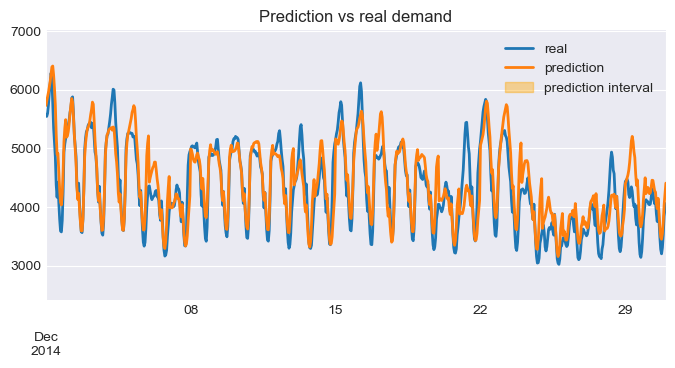

In [62]:

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'Demand'].plot(linewidth=2, label='real', ax=ax)
predictions.iloc[:, 0].plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.fill_between(
    predictions.index,
    predictions.iloc[:, 1],
    predictions.iloc[:, 2],
    alpha = 0.4,
    color = 'orange',
    label = 'prediction interval' 
)
ax.legend();


In [63]:

# Predicted interval coverage
# ==============================================================================
inside_interval = np.where(
                      (data.loc[end_validation:, 'Demand'] >= predictions["lower_bound"]) & \
                      (data.loc[end_validation:, 'Demand'] <= predictions["upper_bound"]),
                      True,
                      False
                  )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")


Predicted interval coverage: 79.03 %


In [64]:

# Anticipating Daily Forecasts:

# End of initial_train_size + 12 positions
# ==============================================================================
data.iloc[:len(data.loc[:end_validation])+12].tail(2)


,Demand,Temperature,Holiday,month,week_day,hour_day
Time,,,,,,
2014-12-01 10:00:00,5084.011257,19.90,0.0,12,1,11
2014-12-01 11:00:00,4851.066658,19.35,0.0,12,1,12


In [65]:

# Backtesting with gap
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['Demand'],
                          steps                 = 24,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data.loc[:end_validation])+12,
                          gap                   = 12,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True  
                      )

print("")
print('Backtesting metric:', metric)
predictions.head(5)


Information of backtesting process
----------------------------------
Number of observations used for initial training: 25572
Number of observations used for backtesting: 708
    Number of folds: 29
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 12

Fold: 0
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-02 00:00:00 -- 2014-12-02 23:00:00  (n=24)
Fold: 1
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-03 00:00:00 -- 2014-12-03 23:00:00  (n=24)
Fold: 2
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-04 00:00:00 -- 2014-12-04 23:00:00  (n=24)
Fold: 3
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-05 00:00:00 -- 2014-12-05 23:00:00  (n=24)
Fold: 4
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-0

  0%|          | 0/29 [00:00<?, ?it/s]


Backtesting metric: 374.337317592686


,pred
2014-12-02 00:00:00,5154.952086
2014-12-02 01:00:00,5183.487126
2014-12-02 02:00:00,5263.237055
2014-12-02 03:00:00,5397.278836
2014-12-02 04:00:00,5571.542647


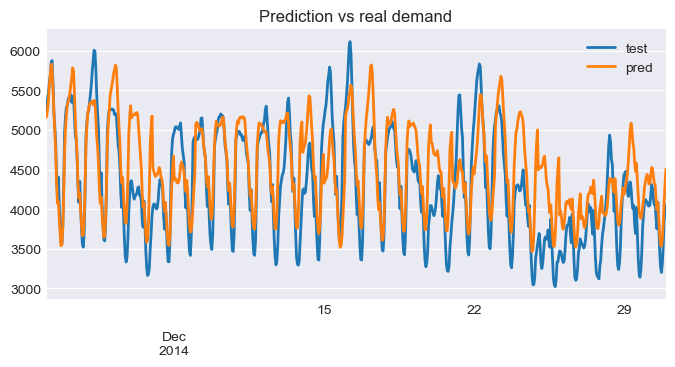

In [66]:

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();


In [67]:

# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'Demand'],
            y_pred = predictions
        )

print(f"Backtest error: {error}")


Backtest error: 374.337317592686


In [68]:

# Predictors importance
# ==============================================================================
forecaster.get_feature_importances()


,feature,importance
0,lag_1,1.027185
1,lag_2,-0.017558
2,lag_3,-0.072357
3,lag_23,0.145979
4,lag_24,0.351853
5,lag_25,-0.471072
6,lag_47,-0.057676
7,lag_48,0.284220
8,lag_49,-0.217552


In [69]:

# The hyperparameters and lags identified as optimal in the previous section are used.

# The Holiday column is converted from boolean to integer
# ==============================================================================
data['Holiday'] = data['Holiday'].astype(int)
data_train['Holiday'] = data_train['Holiday'].astype(int)
data_test['Holiday'] = data_test['Holiday'].astype(int)

# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = Ridge(alpha=215.44, random_state=123),
                 lags             = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                 transformer_y    = StandardScaler(),
                 transformer_exog = None
             )

forecaster.fit(y=data.loc[:end_validation, 'Demand'], exog=data.loc[:end_validation, 'Holiday'])
forecaster


ForecasterAutoreg 
Regressor: Ridge(alpha=215.44, random_state=123) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: Holiday 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 215.44, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-08-28 22:44:49 
Last fit date: 2023-08-28 22:44:49 
Skforecast version: 0.9.1 
Python version: 3.10.9 
Forecaster id: None 

  0%|          | 0/29 [00:00<?, ?it/s]

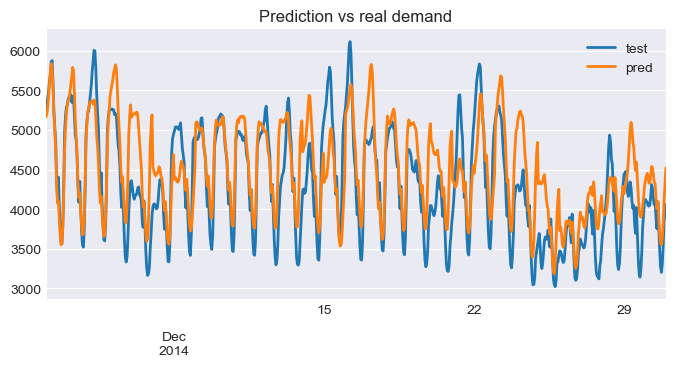

In [70]:

# Anticipating Daily Forecasts:

# Backtest with gap
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['Demand'],
                          exog                  = data['Holiday'],
                          steps                 = 24,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data.loc[:end_validation])+12,
                          gap                   = 12,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True  
                      )

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();


In [71]:

# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'Demand'],
            y_pred = predictions
        )

print(f"Backtest error: {error}")


Backtest error: 359.10771907712905


In [72]:

# Creation of new exogenous variables
# ==============================================================================
# Since it is hourly data and starts at 00:00, the values must be shifted 
# by 24 hours
data['Holiday_day_before'] = data['Holiday'].shift(24)
data['Holiday_next_day']   = data['Holiday'].shift(-24)
data = data.dropna()

# One hot encoding of week_day and hour_day
# ==============================================================================
one_hot_encoder = make_column_transformer(
                      (
                          OneHotEncoder(sparse_output=False, drop='if_binary'),
                          ['week_day', 'hour_day'],
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

data = one_hot_encoder.fit_transform(data)
data.head(3)


,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,week_day_7,hour_day_1,hour_day_2,hour_day_3,...,hour_day_21,hour_day_22,hour_day_23,hour_day_24,Demand,Temperature,Holiday,month,Holiday_day_before,Holiday_next_day
Time,,,,,,,,,,,,,,,,,,,,,
2012-01-02 00:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5262.895338,32.825,1,1,1.0,0.0
2012-01-02 01:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,5786.043417,34.500,1,1,1.0,0.0
2012-01-02 02:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,6236.144167,36.725,1,1,1.0,0.0


In [73]:

# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = Ridge(alpha=215.44, random_state=123),
                 lags             = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                 transformer_y    = StandardScaler(),
                 transformer_exog = None
             )

exog = [col for col in data.columns if col.startswith(('week_day', 'hour', 'Holiday'))]
forecaster.fit(y=data.loc[:end_validation, 'Demand'], exog=data.loc[:end_validation, exog])

# Backtest with gap
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['Demand'],
                          exog                  = data[exog],
                          steps                 = 24,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data.loc[:end_validation])+12,
                          gap                   = 12,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True  
                      )

# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'Demand'],
            y_pred = predictions
        )

print("")
print(f"Backtest error: {error}")


  0%|          | 0/28 [00:00<?, ?it/s]


Backtest error: 298.6117850920278


In [ ]:

# As temperature is also available in the dataset and is related to Demand, it may be tempting to include it as 
# a predictor. However, this approach would not be correct as the future temperature is unknown. It is possible 
# to use the temperature forecast as a predictor for the model, but in this case the model would have to be 
# trained on the forecast temperature, not the actual one. 


In [74]:

# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor        = LGBMRegressor(random_state=123),
                 steps            = 36, # Steps + gap
                 lags             = 24, # This value will be replaced in the grid search
                 transformer_y    = None,
                 transformer_exog = None
             )

# Lags used as predictors
lags_grid = [[1, 2, 3, 23, 24], [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [4, 6]}

results_grid = grid_search_forecaster(
                   forecaster            = forecaster,
                   y                     = data.loc[:end_validation, 'Demand'],
                   exog                  = data.loc[:end_validation, exog],
                   steps                 = 24,
                   metric                = 'mean_absolute_error',
                   param_grid            = param_grid,
                   lags_grid             = lags_grid,
                   initial_train_size    = len(data.loc[:end_train])+12,
                   gap                   = 12,
                   allow_incomplete_fold = True,
                   refit                 = False,
                   return_best           = True,
                   n_jobs                = 'auto',
                   verbose               = False,
                   show_progress         = True
               )


Number of models compared: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

<frozen importlib._bootstrap>:914: ImportWarning:

_SixMetaPathImporter.find_spec() not found; falling back to find_module()



`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'max_depth': 6, 'n_estimators': 500}
  Backtesting metric: 243.65601976494384



In [75]:

# Grid Search results
# ==============================================================================
results_grid


,lags,params,mean_absolute_error,max_depth,n_estimators
7,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 6, 'n_estimators': 500}",243.656020,6,500
3,"[1, 2, 3, 23, 24]","{'max_depth': 6, 'n_estimators': 500}",246.156925,6,500
5,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 4, 'n_estimators': 500}",251.087154,4,500
1,"[1, 2, 3, 23, 24]","{'max_depth': 4, 'n_estimators': 500}",254.086127,4,500
2,"[1, 2, 3, 23, 24]","{'max_depth': 6, 'n_estimators': 100}",272.986569,6,100
6,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 6, 'n_estimators': 100}",273.278625,6,100
0,"[1, 2, 3, 23, 24]","{'max_depth': 4, 'n_estimators': 100}",307.270799,4,100
4,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 4, 'n_estimators': 100}",307.566413,4,100


  0%|          | 0/28 [00:00<?, ?it/s]

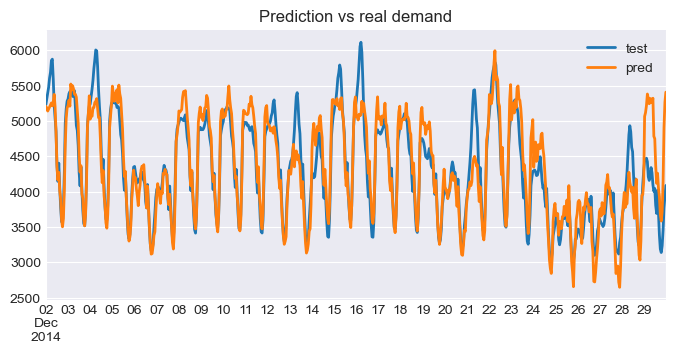

In [76]:

# Backtest with gap
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['Demand'],
                          exog                  = data[exog],
                          steps                 = 24,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data.loc[:end_validation])+12,
                          gap                   = 12,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True  
                      )

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();


In [77]:

# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'Demand'],
            y_pred = predictions
        )

print(f"Backtest error: {error}")


Backtest error: 222.42852414702134


In [ ]:

# All logic came from the following resource.
# https://cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html

# This is certainly NOT my own work! I found this link from a Google search and I'm inclusing it on my blog because 
# I think the example is very interesting and it seems to have many practical applications, either directly as-is, 
# or with some slight modifications to the code samples given.
